# 0. Introduction

In this notebook investigate the dataset that is composed of selected tables, columns and row from the "crunchbase 2013 snapshot"
This dataset was created in the "data_gathering" notebook

We will apply data cleaning and feature engineering to make sure we get a clean dataset
Afterwards we will look at the values and distributions of the variables that are available
Lastly we will create the dataset that will be used for modelling

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import normaltest
from scipy.stats import spearmanr

In [79]:
sns.set_theme(palette="colorblind", rc={'figure.figsize':(14, 10)})

In [80]:
df = pd.read_csv(r"C:\Users\32474\Documents\Ma TEW\masterthesis\data\merged_data.csv")

In [81]:
# drop the index count that was saved when keeping the data as csv
df.drop("Unnamed: 0", axis=1, inplace=True)

# 1. Feature engineering

## 1.1. FIll missing

In [82]:
df.acquirer_offices.fillna(0, inplace=True)

In [83]:
df.acquired_offices.fillna(0, inplace=True)

## 1.2. Change the data type

### 1.2.1. Deal variables

In [84]:
df["acquired_at"] = df["acquired_at"].apply(pd.to_datetime, errors="coerce")

### 1.2.2. Acquirer

In [85]:
df.acquirer_founded_year = df.acquirer_founded_year.astype(np.int64)
df.acquirer_total_funding = df.acquirer_total_funding.astype(np.int64)
df.acquirer_offices = df.acquirer_offices.astype(np.int64)

### 1.2.3. Acquired

In [86]:
df.acquired_founded_year = df.acquired_founded_year.astype(np.int64)
df.acquirer_total_funding = df.acquirer_total_funding.astype(np.int64)
df.acquirer_offices = df.acquirer_offices.astype(np.int64)
df.funds_backing_acquired = df.funds_backing_acquired.astype(np.int64)

## 1.3. Change variables

In [87]:
# This is the average exchange rate from 1993 till 2013
# exchange rates from top fxtop.com

def convert_to_usd(data):
    conversion_rates = {
        'USD': 1,
        'EUR': 1.3791,
        'CAD': 0.940018,
        'GBP': 1.654192,
        'JPY': 0.009529,
        'AUD': 0.894184,
        'SEK': 0.15567,
    }
    return round(data['price_amount'] * conversion_rates[data['price_currency_code']], 0)

In [88]:
df["deal_price"] = df.apply(convert_to_usd, axis=1)

In [89]:
# Create industry sector mapping
industry_sector_mapping = {
    "other": "other",
    "web": "IT",
    "search": "IT",
    "news": "communication",
    "software": "IT",
    "games_video": "communication",
    "mobile": "communication",
    "enterprise": "other",
    "advertising": "consumer_discretionary",
    "security": "other",
    "hardware": "IT",
    "public_relations": "industrials",
    "finance": "financials",
    "ecommerce": "IT",
    "network_hosting": "communication",
    "consulting": "industrials",
    "biotech": "health_care",
    "social": "IT",
    "cleantech": "other",
    "semiconductor": "IT",
    "transportation": "industrials",
    "legal": "industrials",
    "manufacturing": "industrials",
    "messaging": "communication",
    "medical": "health_care",
    "automotive": "consumer_discretionary",
    "analytics": "IT",
    "travel": "consumer_discretionary",
    "health": "health_care",
    "real_estate": "financials",
    "music": "communication",
    "photo_video": "communication",
    "education": "other",
    "fashion": "consumer_discretionary",
    "hospitality": "consumer_discretionary",
    "local": "consumer_discretionary",
    "nanotech": "industrials",
}

In [90]:
# map industry to sector for acquirer and acquired
df["acquirer_sector"] = df.acquirer_industry.map(industry_sector_mapping)
df["acquired_sector"] = df.acquired_industry.map(industry_sector_mapping)

In [91]:
# create dummy variables for the sector
df = pd.concat([df, pd.get_dummies(df.acquirer_sector, prefix="acquirer_sector")], axis=1)
df = pd.concat([df, pd.get_dummies(df.acquired_sector, prefix="acquired_sector")], axis=1)

In [92]:
# log scale the deal price
df["log_deal_price"] = np.log(df["deal_price"])

### 1.3.1. Dummy variables

#### Acquirer

In [93]:
# Create a dummy indicating if the company is from the USA
df["acquirer_is_usa"] = np.where(df.acquirer_country == "USA", 1, 0)

In [94]:
# Create a dummy indicating if the company is from the SF Bay region
df["acquirer_is_bay"] = np.where(df.acquirer_region == "SF Bay", 1, 0)

#### Acquired

In [95]:
# Create a dummy indicating if the company is from the USA
df["acquired_is_usa"] = np.where(df.acquired_country == "USA", 1, 0)

In [96]:
# Create a dummy indicating if the company is from the SF Bay region
df["acquired_is_bay"] = np.where(df.acquired_region == "SF Bay", 1, 0)

In [97]:
df["founder_has_degree"] = np.where((df.highest_degree_founder == "Bachelor")
                                    | (df.highest_degree_founder == "Master")
                                    | (df.highest_degree_founder == "MBA")
                                    | (df.highest_degree_founder == "Phd"),
                                    1, 0)

### 1.3.2. New variables

In [98]:
# get the number of acquisitions that are available for each acquirer
df["acquirer_number_of_acquisitions"] = df.groupby("name_acquirer")["name_acquirer"].transform("count")

In [99]:
# get the year the acquisition was made
df["acquisition_year"] = df["acquired_at"].dt.year

In [100]:
# indicates if the acquired and acquirer are from the same company
df["same_country"] = np.where(df.acquirer_country == df.acquired_country, 1, 0)

In [101]:
# indicates if the acquired and acquirer are from the same sector
df["same_sector"] = np.where(df.acquirer_sector == df.acquired_sector, 1, 0)

In [102]:
# age at acquisition
df["acquirer_age"] = df.acquisition_year - df.acquirer_founded_year

In [103]:
# age at acquisition
df["acquired_age"] = df.acquisition_year - df.acquired_founded_year

## 1.4. Drop Cases

In [104]:
# Drop 26 cases where the founding date of the acquired is after the acquisition date
df.drop(df[(df["acquisition_year"] < df["acquired_founded_year"])].index, inplace=True)

In [105]:
# Drop 7 cases where the founding date of the acquirer is after the acquisition date
df.drop(df[(df["acquisition_year"] < df["acquirer_founded_year"])].index, inplace=True)

In [106]:
# drop the case (1) were the acquired startup is not in the usa, but is from the bay. This can not be right
df.drop(df[(df["acquired_is_usa"] == 0) & (df["acquired_is_bay"] == 1)].index, inplace=True)

In [107]:
# Drop the deals with a price less than 10000, this price is probably a mistake (ie expressed in million dollars instead of just dollars)
# even if they are correct they will probably throw the model off and not be of interest any way
df.drop(df[df.deal_price < 10000].index, inplace=True)

In [108]:
df.drop_duplicates(keep="first", inplace=True)

# 2. Visualise and data exploration

In [111]:
# function for the significance of the correlation matrix
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(spearmanr(df[r], df[c])[1], 4)
    return pvalues

In [112]:
df.shape

(2478, 58)

## 2.1. Deal Variables

In [113]:
deal_columns = [
    'log_deal_price','acquisition_year', 'same_country', 'same_sector'
]

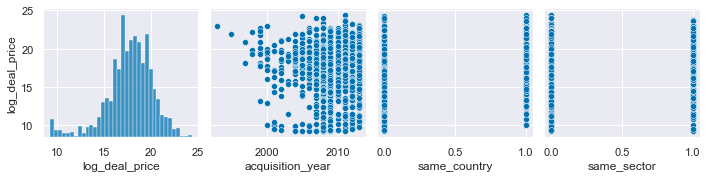

In [114]:
sns.pairplot(data=df,
             x_vars=deal_columns,
             y_vars="log_deal_price")

In [115]:
deal_corr = df[deal_columns].corr(method="spearman").round(2)

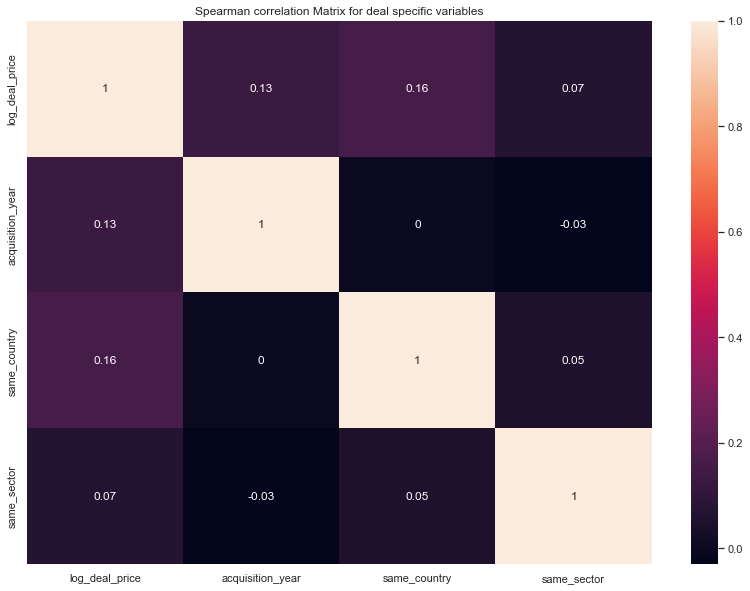

In [116]:
sns.heatmap(deal_corr, annot=True)
plt.title("Spearman correlation Matrix for deal specific variables")
plt.savefig(r"C:\Users\32474\Documents\Ma TEW\masterthesis\grafieken\correlation_matrix_deal_specific", bbox_inches='tight')

In [117]:
calculate_pvalues(df[deal_columns])

,log_deal_price,acquisition_year,same_country,same_sector
log_deal_price,0.0,0.0,0.0,0.0004
acquisition_year,0.0,0.0,0.905,0.157
same_country,0.0,0.905,0.0,0.009
same_sector,0.0004,0.157,0.009,0.0


**insight**
All deal specific variables seem to correlate significantly with the deal_price

### 2.1.1. Year

In [118]:
# min max of the year and most common values
df.acquisition_year.describe()

count    2478.000000
mean     2009.622276
std         2.718858
min      1993.000000
25%      2008.000000
50%      2010.000000
75%      2012.000000
max      2013.000000
Name: acquisition_year, dtype: float64

Text(0.5, 1.0, 'Density plot of acquisitions per year')

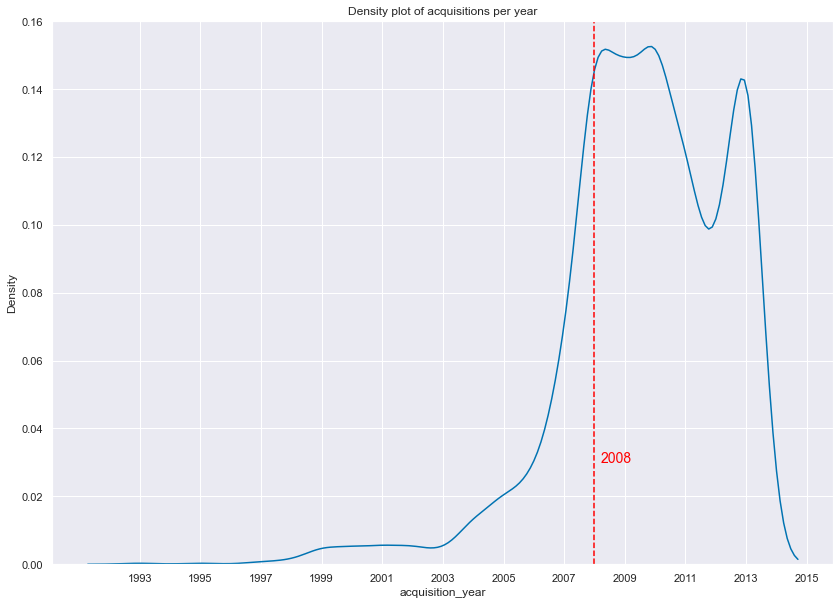

In [119]:
g = sns.kdeplot(data=df, x="acquisition_year")
g.set_xticks(range(1993, 2016, 2))
plt.axvline(2008, color="red", linestyle="--")
plt.text(2008.2, 0.03, "2008", fontsize=14, color="red")
plt.title("Density plot of acquisitions per year")

Text(0.5, 1.0, 'Histogram for the number of acquisitions per year')

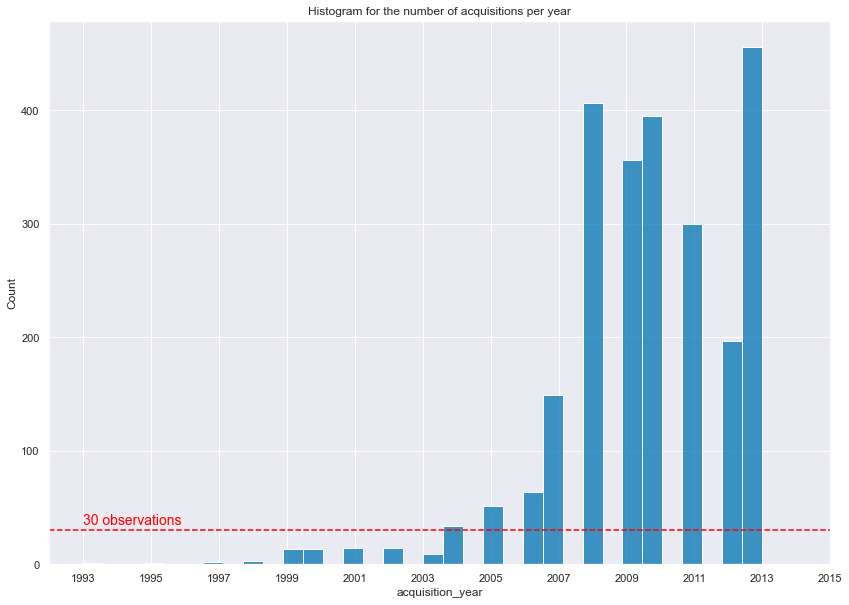

In [120]:
h = sns.histplot(data=df, x="acquisition_year")
h.set_xticks(range(1993, 2016, 2))
plt.axhline(30, color="red", linestyle="--")
plt.text(1993, 35, "30 observations", fontsize=14, color="red")
plt.title("Histogram for the number of acquisitions per year")

### 2.1.2. Price

Text(0.5, 1.0, 'Density for log deal price')

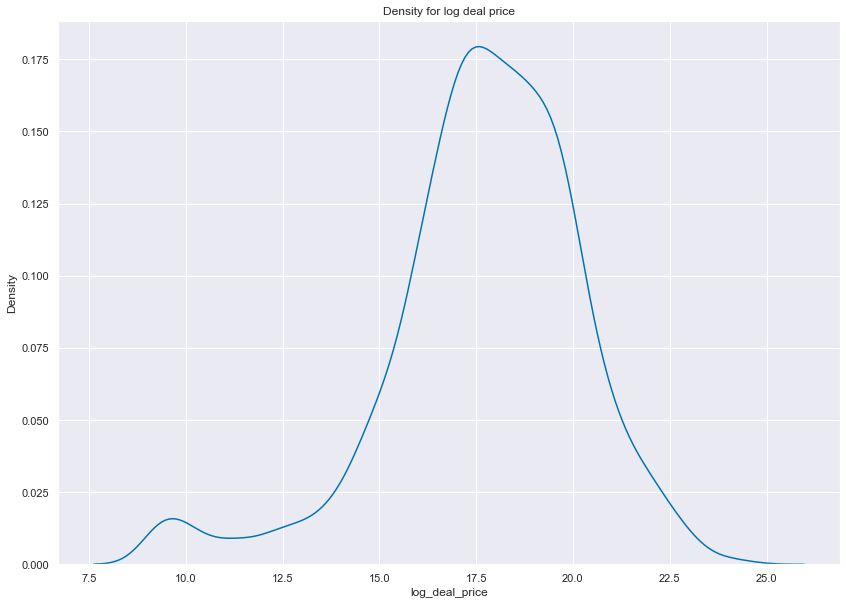

In [121]:
sns.kdeplot(data=df, x="log_deal_price")
plt.title("Density for log deal price")

In [122]:
# test if deal_price is log normal (H0: price is log normal)
normaltest(np.log(df.deal_price))

NormaltestResult(statistic=329.2808461822946, pvalue=3.1446531705096615e-72)

In [123]:
# total amount of M&A transactions
df.deal_price.sum()

1114362952901.0

In [124]:
# M&A transactions of biggest 25%
df[df.deal_price > 268_000_000]['deal_price'].sum()

1007926380374.0

In [125]:
# impact of the top 25% on the total amount
df[df.deal_price > 268_000_000]['deal_price'].sum() / df.deal_price.sum()

0.9044866196871354

In [126]:
# min and max of deal price
df.deal_price.describe()

count    2.478000e+03
mean     4.497026e+08
std      1.780006e+09
min      1.000000e+04
25%      1.492500e+07
50%      6.000000e+07
75%      2.680000e+08
max      3.900000e+10
Name: deal_price, dtype: float64

Text(0.5, 1.0, 'Average deal price throughout time')

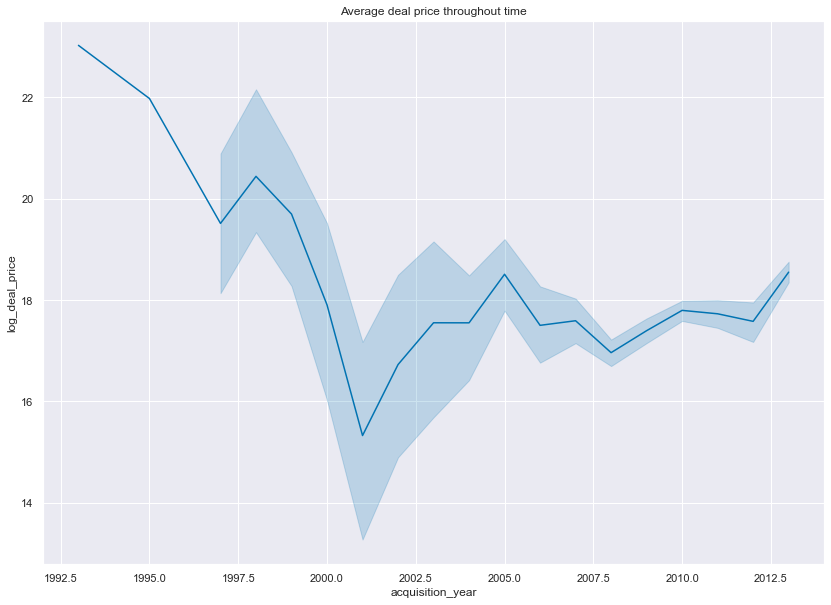

In [127]:
sns.lineplot(data=df, x="acquisition_year" , y="log_deal_price")
plt.title("Average deal price throughout time")

**Insight**
- most acquisitions between 2008 and 2013
- most deals between 1 000 000 and 10 000 000 000
- do prices tend to spike before crisis? 2000 and 2005 (last one didn't last until crisis)

## 2.2 Acquirer variables

In [128]:
acquirer_columns = [
    'log_deal_price', 'deal_price', 'acquirer_investment_rounds', 'acquirer_funding_rounds', 'acquirer_milestones', 'acquirer_relationships', 'acquirer_founded_year',
    'acquirer_offices', 'acquirer_is_usa', 'acquirer_is_bay', 'acquirer_sector_IT', 'acquirer_sector_communication', 'acquirer_sector_consumer_discretionary',
    'acquirer_sector_financials', 'acquirer_sector_health_care', 'acquirer_sector_industrials', 'acquirer_sector_other', 'acquirer_number_of_acquisitions', 'acquirer_age',
]

In [129]:
acquirer_corr = df[acquirer_columns].corr(method="spearman").round(2)

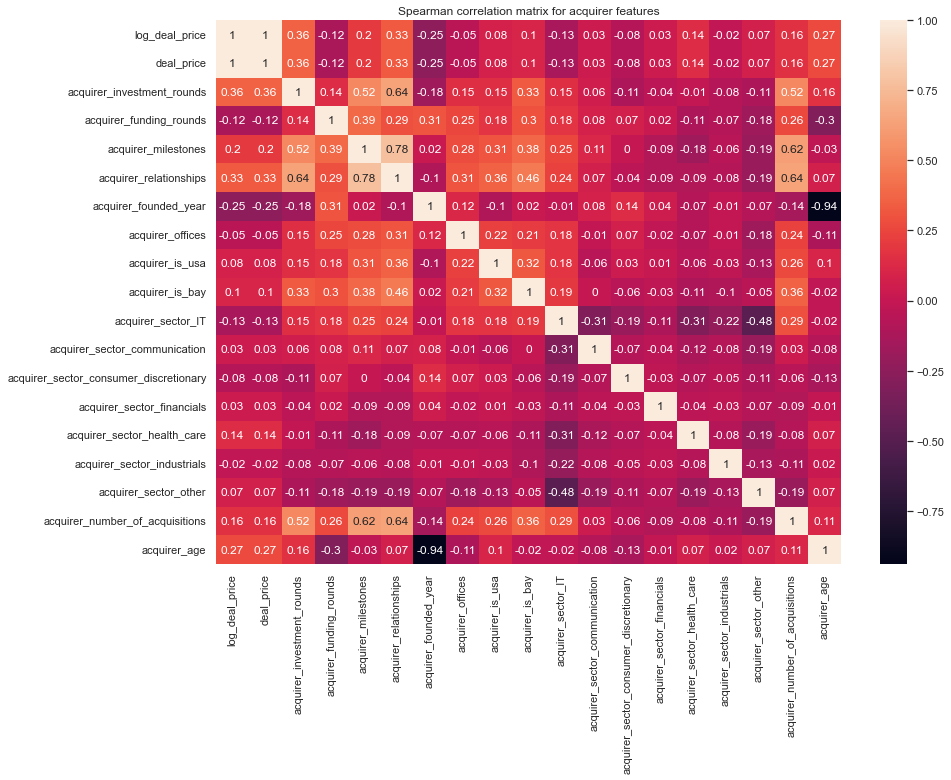

In [130]:
sns.set(rc={'figure.figsize':(14,10)})
sns.heatmap(acquirer_corr, annot=True)
plt.title("Spearman correlation matrix for acquirer features")
plt.savefig(r"C:\Users\32474\Documents\Ma TEW\masterthesis\grafieken\correlation_matrix_acquirer", bbox_inches='tight')

In [131]:
calculate_pvalues(df[acquirer_columns])

,log_deal_price,deal_price,acquirer_investment_rounds,acquirer_funding_rounds,acquirer_milestones,acquirer_relationships,acquirer_founded_year,acquirer_offices,acquirer_is_usa,acquirer_is_bay,acquirer_sector_IT,acquirer_sector_communication,acquirer_sector_consumer_discretionary,acquirer_sector_financials,acquirer_sector_health_care,acquirer_sector_industrials,acquirer_sector_other,acquirer_number_of_acquisitions,acquirer_age
log_deal_price,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0126,0.0,0.0,0.0,0.1071,0.0,0.1517,0.0,0.307,0.0006,0.0,0.0
deal_price,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0126,0.0,0.0,0.0,0.1071,0.0,0.1517,0.0,0.307,0.0006,0.0,0.0
acquirer_investment_rounds,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0033,0.0,0.0783,0.4864,0.0001,0.0,0.0,0.0
acquirer_funding_rounds,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0001,0.0006,0.446,0.0,0.0004,0.0,0.0,0.0
acquirer_milestones,0.0,0.0,0.0,0.0,0.0,0.0,0.3643,0.0,0.0,0.0,0.0,0.0,0.9359,0.0,0.0,0.0024,0.0,0.0,0.1142
acquirer_relationships,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0006,0.0502,0.0,0.0,0.0001,0.0,0.0,0.0002
acquirer_founded_year,0.0,0.0,0.0,0.0,0.3643,0.0,0.0,0.0,0.0,0.412,0.536,0.0,0.0,0.0463,0.0009,0.7425,0.0002,0.0,0.0
acquirer_offices,0.0126,0.0126,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5027,0.0002,0.3033,0.0007,0.5935,0.0,0.0,0.0
acquirer_is_usa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0059,0.0908,0.6182,0.0031,0.082,0.0,0.0,0.0
acquirer_is_bay,0.0,0.0,0.0,0.0,0.0,0.0,0.412,0.0,0.0,0.0,0.0,0.8465,0.0038,0.1645,0.0,0.0,0.0083,0.0,0.2359


**Insight**
All variables correlate significantly with deal price except for following sectors: communication, financials, industrials

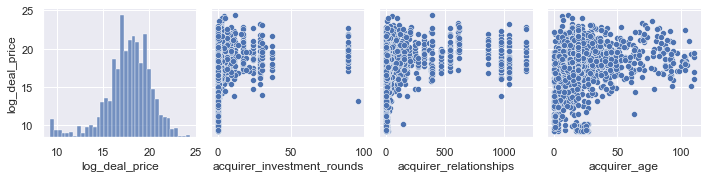

In [132]:
# compare the most important variables to deal price
sns.pairplot(data=df,
             x_vars=["log_deal_price", "acquirer_investment_rounds", "acquirer_relationships", "acquirer_age"],
             y_vars="log_deal_price")

In [133]:
# Select the unique acquirers that match on all variables except for deal_price and age (at time of deal) because these are deal dependant
acquirers = df[acquirer_columns].drop_duplicates(acquirer_columns[2: -1])

In [134]:
acquirers.shape

(1263, 19)

### 2.2.1. Year

Text(0.5, 1.0, 'Regression plot for acquirer founding year and the log deal price')

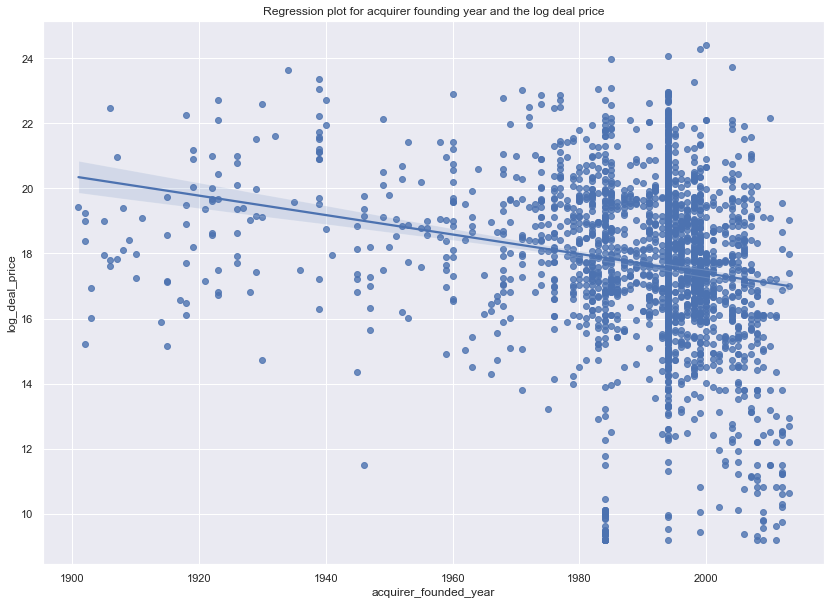

In [135]:
sns.regplot(data= df, x="acquirer_founded_year", y="log_deal_price")
plt.title("Regression plot for acquirer founding year and the log deal price")

### 2.2.2. Sector

In [136]:
df.groupby("acquirer_sector")['deal_price'].aggregate(np.mean).reset_index().sort_values("deal_price")["acquirer_sector"]

2    consumer_discretionary
5               industrials
0                        IT
6                     other
4               health_care
1             communication
3                financials
Name: acquirer_sector, dtype: object

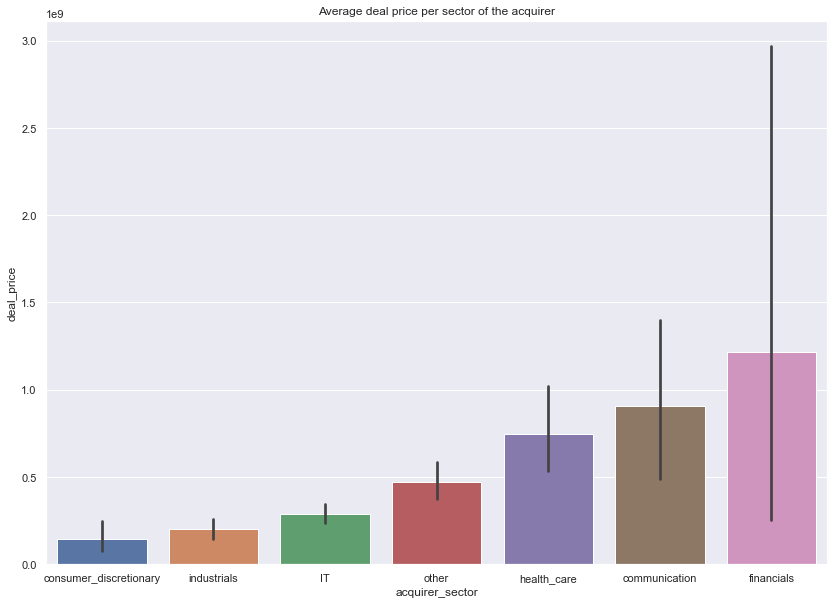

In [137]:
order = df.groupby("acquirer_sector")['deal_price'].aggregate(np.mean).reset_index().sort_values("deal_price")["acquirer_sector"]
sns.barplot(data=df, x="acquirer_sector", y="deal_price", order=order)
plt.title("Average deal price per sector of the acquirer")
plt.savefig(r"C:\Users\32474\Documents\Ma TEW\masterthesis\grafieken\acquirer_price_per_sector")

Text(0.5, 1.0, 'Density of acquisitions per sector of acquirer')

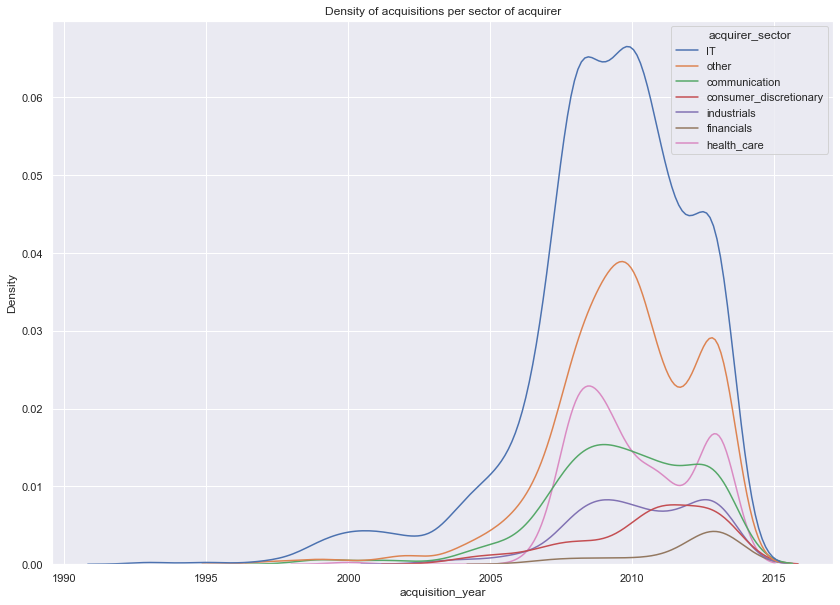

In [138]:
sns.kdeplot(data=df, x="acquisition_year", hue="acquirer_sector")
plt.title("Density of acquisitions per sector of acquirer")

### 2.2.3. Location

Text(0.5, 1.0, 'Average deal price for the location of the acquirer')

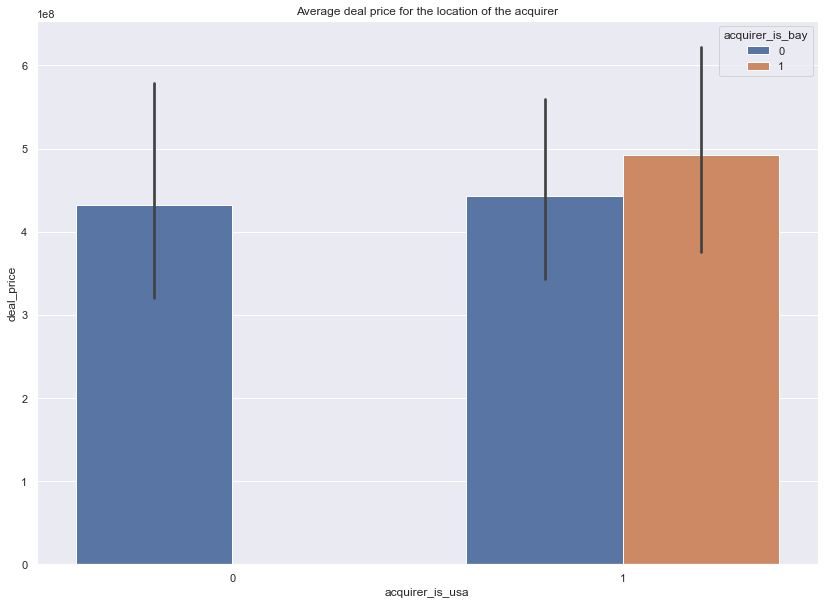

In [139]:
sns.barplot(data=df, x="acquirer_is_usa", y="deal_price", hue="acquirer_is_bay")
plt.title("Average deal price for the location of the acquirer")

### 2.2.4. Investment and funding

Text(0.5, 1.0, 'Regression plot for the investments of the acquirer and the log deal price')

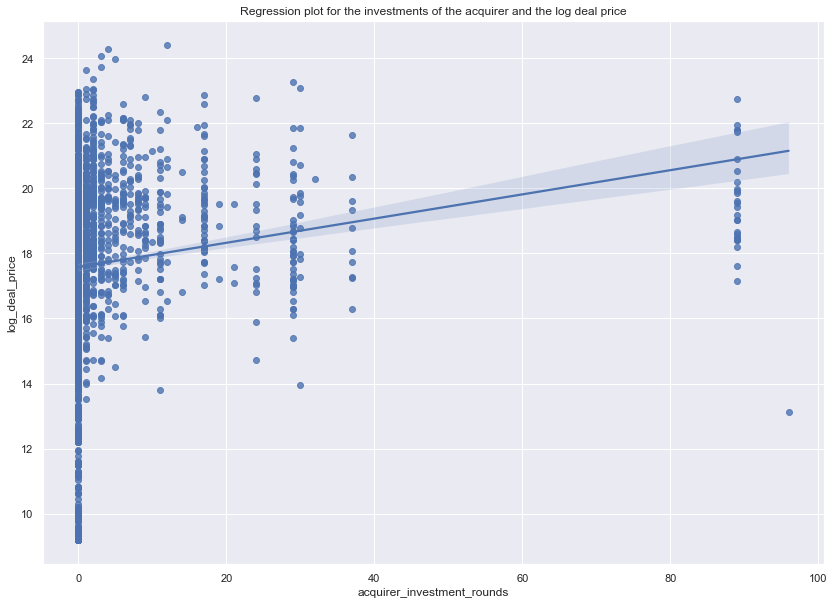

In [140]:
sns.regplot(data=df, x="acquirer_investment_rounds", y="log_deal_price")
plt.title("Regression plot for the investments of the acquirer and the log deal price")

Text(0.5, 1.0, 'Regression plot for the funding of the acquirer and the log deal price')

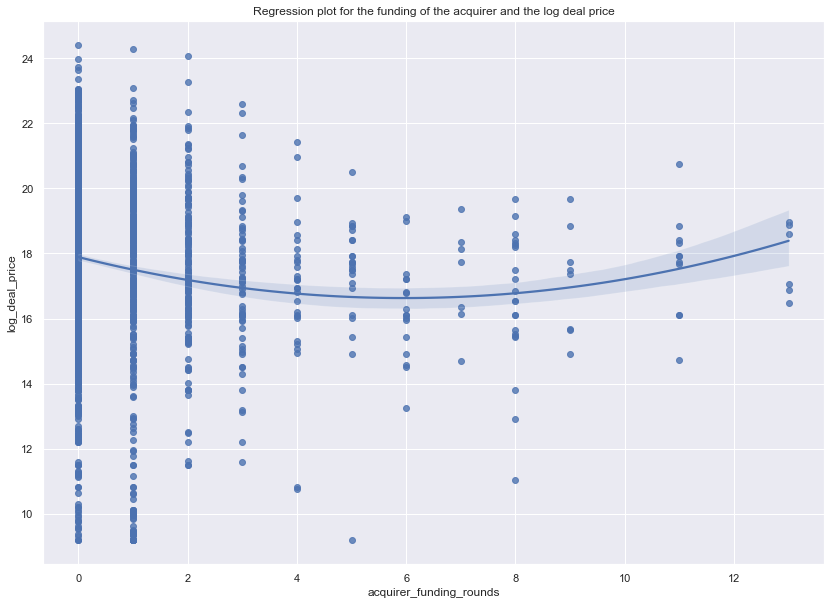

In [141]:
sns.regplot(data=df, x="acquirer_funding_rounds", y="log_deal_price", order=2)
plt.title("Regression plot for the funding of the acquirer and the log deal price")

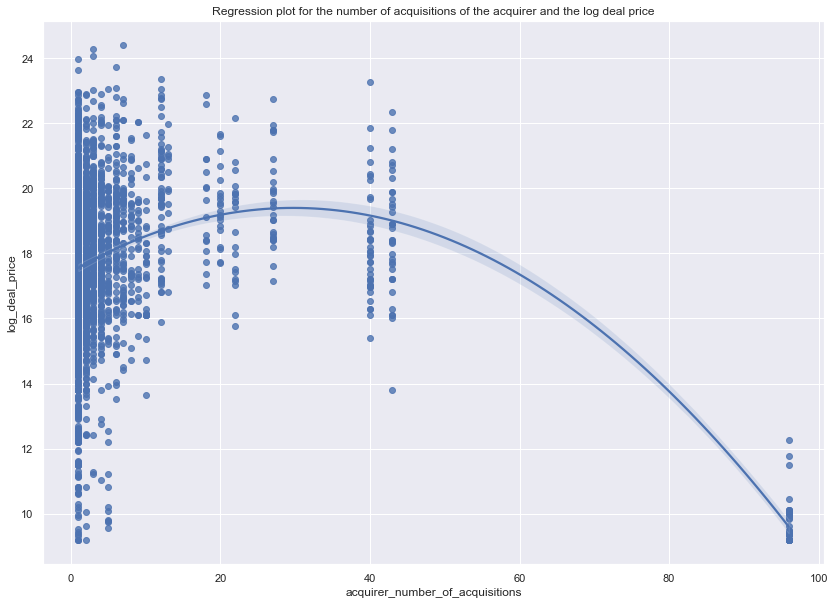

In [142]:
sns.regplot(data=df, x="acquirer_number_of_acquisitions", y="log_deal_price", order=2)
plt.title("Regression plot for the number of acquisitions of the acquirer and the log deal price")
plt.savefig(r"C:\Users\32474\Documents\Ma TEW\masterthesis\grafieken\acquirer_regression_number_acquisitions")

### 2.2.5. Size

Text(0.5, 1.0, 'Regression plot for the milestones of the acquirer and the log deal price')

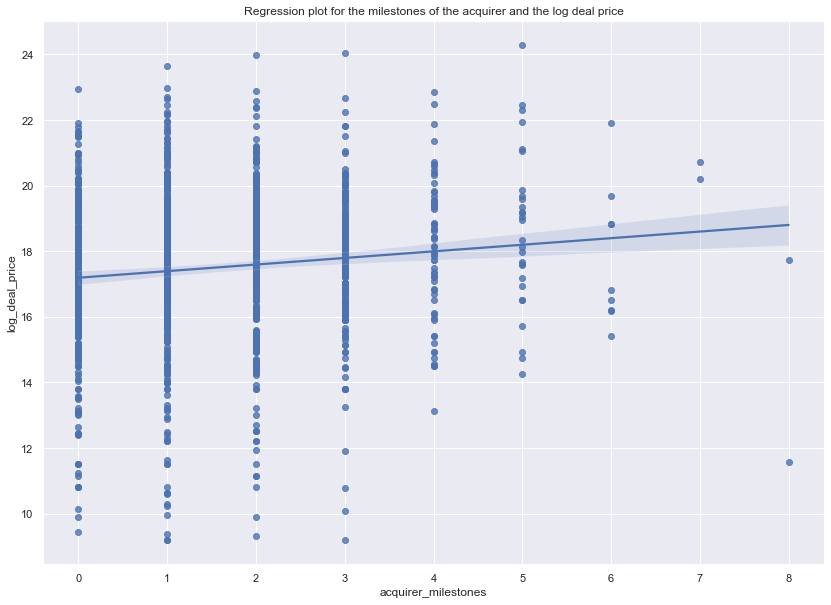

In [143]:
sns.regplot(data=acquirers, x="acquirer_milestones", y="log_deal_price")
plt.title("Regression plot for the milestones of the acquirer and the log deal price")

Text(0.5, 1.0, 'Regression plot for the relationships of the acquirer and the log deal price')

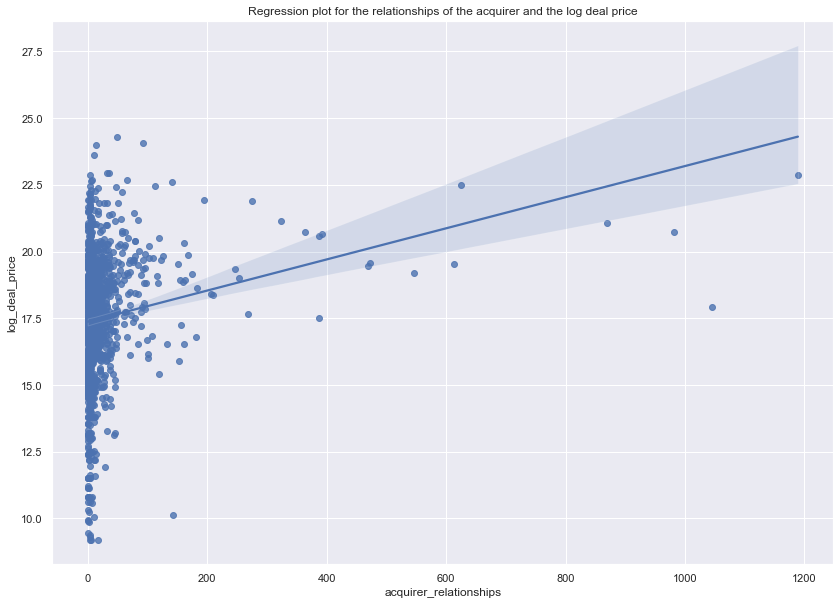

In [144]:
sns.regplot(data=acquirers, x="acquirer_relationships", y="log_deal_price")
plt.title("Regression plot for the relationships of the acquirer and the log deal price")

Text(0.5, 1.0, "Regression plot for the acquirer's number of offices and the log deal price")

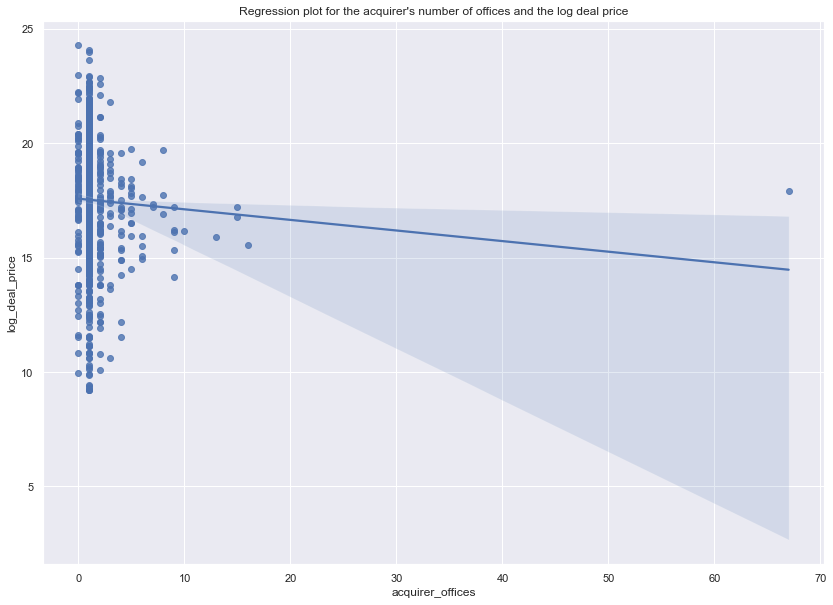

In [145]:
sns.regplot(data=acquirers, x="acquirer_offices", y="log_deal_price")
plt.title("Regression plot for the acquirer's number of offices and the log deal price")

Text(0.5, 1.0, "Regression plot for the acquirer's age and the log deal price")

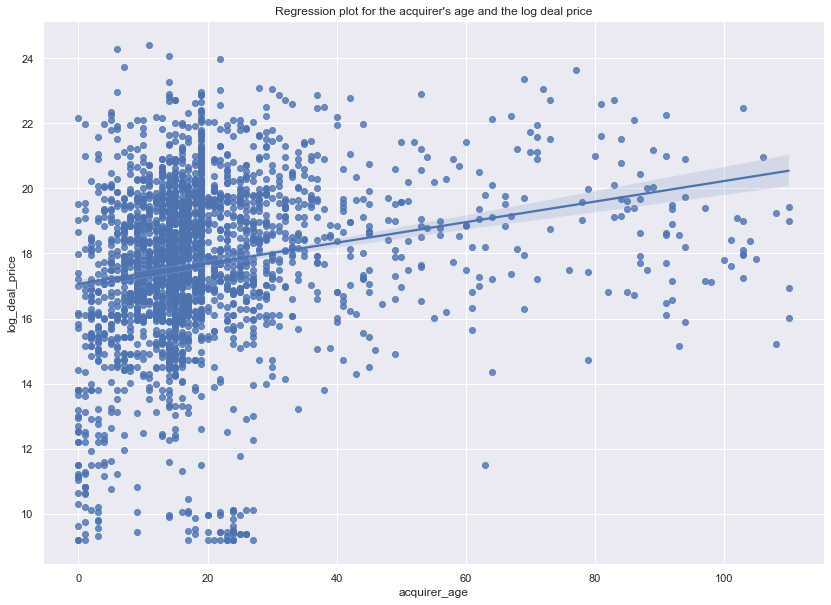

In [146]:
sns.regplot(data=df, x="acquirer_age", y="log_deal_price")
plt.title("Regression plot for the acquirer's age and the log deal price")

## 2.3 Acquired variables

In [147]:
acquired_columns = [
    'log_deal_price', 'deal_price', 'acquired_investment_rounds', 'acquired_funding_rounds', 'acquired_milestones', 'acquired_relationships', 'acquired_founded_year',
    'funds_backing_acquired', 'acquired_offices', 'acquired_is_usa', 'acquired_is_bay', 'founder_has_degree', 'acquired_sector_IT', 'acquired_sector_communication',
    'acquired_sector_consumer_discretionary', 'acquired_sector_financials', 'acquired_sector_health_care', 'acquired_sector_industrials', 'acquired_sector_other',
    'acquired_age',
]

In [148]:
acquired_corr = df[acquired_columns].corr(method="spearman").round(2)

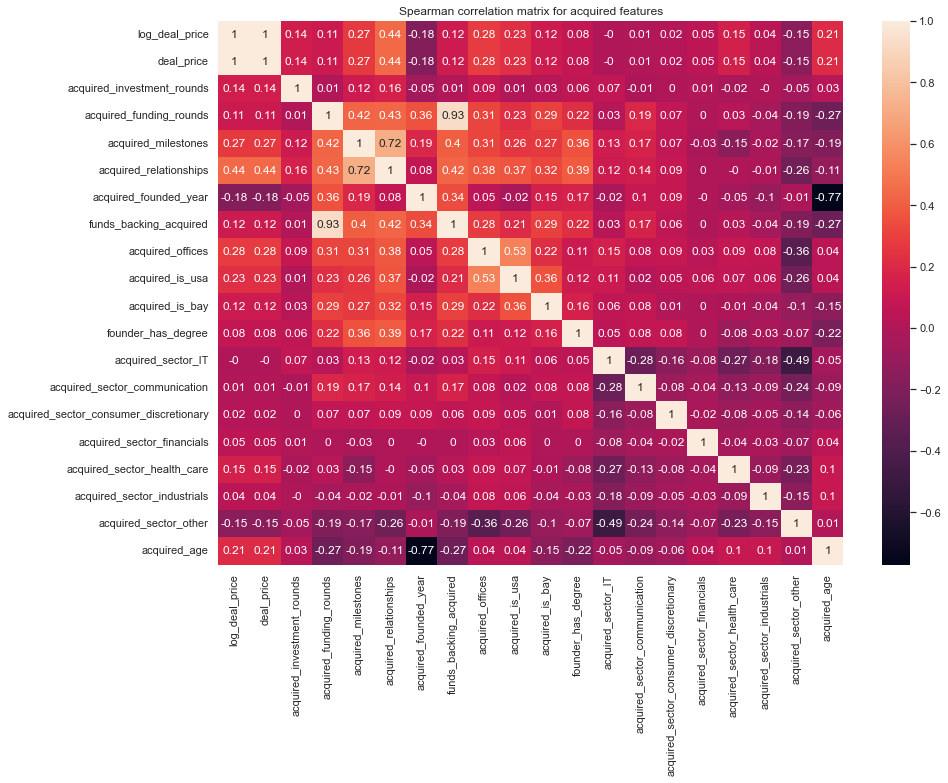

In [149]:
sns.set(rc={'figure.figsize':(14,10)})
sns.heatmap(acquired_corr, annot=True)
plt.title("Spearman correlation matrix for acquired features")
plt.savefig(r"C:\Users\32474\Documents\Ma TEW\masterthesis\grafieken\correlation_matrix_acquired", bbox_inches='tight')

In [150]:
calculate_pvalues(df[acquired_columns])

,log_deal_price,deal_price,acquired_investment_rounds,acquired_funding_rounds,acquired_milestones,acquired_relationships,acquired_founded_year,funds_backing_acquired,acquired_offices,acquired_is_usa,acquired_is_bay,founder_has_degree,acquired_sector_IT,acquired_sector_communication,acquired_sector_consumer_discretionary,acquired_sector_financials,acquired_sector_health_care,acquired_sector_industrials,acquired_sector_other,acquired_age
log_deal_price,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0001,0.8086,0.6189,0.4024,0.0099,0.0,0.0343,0.0,0.0
deal_price,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0001,0.8086,0.6189,0.4024,0.0099,0.0,0.0343,0.0,0.0
acquired_investment_rounds,0.0,0.0,0.0,0.7276,0.0,0.0,0.0084,0.7574,0.0,0.5864,0.1099,0.0028,0.0011,0.6214,0.8052,0.6429,0.2608,0.8677,0.0147,0.1913
acquired_funding_rounds,0.0,0.0,0.7276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2105,0.0,0.001,0.8324,0.1323,0.0389,0.0,0.0
acquired_milestones,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0002,0.182,0.0,0.3419,0.0,0.0
acquired_relationships,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.9712,0.8882,0.5868,0.0,0.0
acquired_founded_year,0.0,0.0,0.0084,0.0,0.0,0.0,0.0,0.0,0.0126,0.287,0.0,0.0,0.3596,0.0,0.0,0.9262,0.0152,0.0,0.6352,0.0
funds_backing_acquired,0.0,0.0,0.7574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0977,0.0,0.0039,0.9003,0.1585,0.0538,0.0,0.0
acquired_offices,0.0,0.0,0.0,0.0,0.0,0.0,0.0126,0.0,0.0,0.0,0.0,0.0,0.0,0.0001,0.0,0.1627,0.0,0.0001,0.0,0.0477
acquired_is_usa,0.0,0.0,0.5864,0.0,0.0,0.0,0.287,0.0,0.0,0.0,0.0,0.0,0.0,0.3104,0.0067,0.0034,0.0003,0.0041,0.0,0.0579


**Insight**
All acquired variables are correlated significantly with deal price except for following sectors: IT, communication and consumer_discretionary

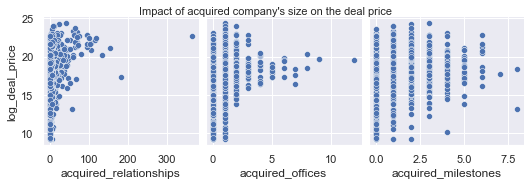

In [151]:
# compare the most important variables to deal price
g = sns.pairplot(data=df,
             x_vars=["acquired_relationships", "acquired_offices", "acquired_milestones"],
             y_vars="log_deal_price")
g.fig.suptitle("Impact of acquired company's size on the deal price", y=1, fontsize=11)
plt.savefig(r"C:\Users\32474\Documents\Ma TEW\masterthesis\grafieken\acquired_size")

### 2.3.1. Year

<AxesSubplot:xlabel='acquired_founded_year', ylabel='log_deal_price'>

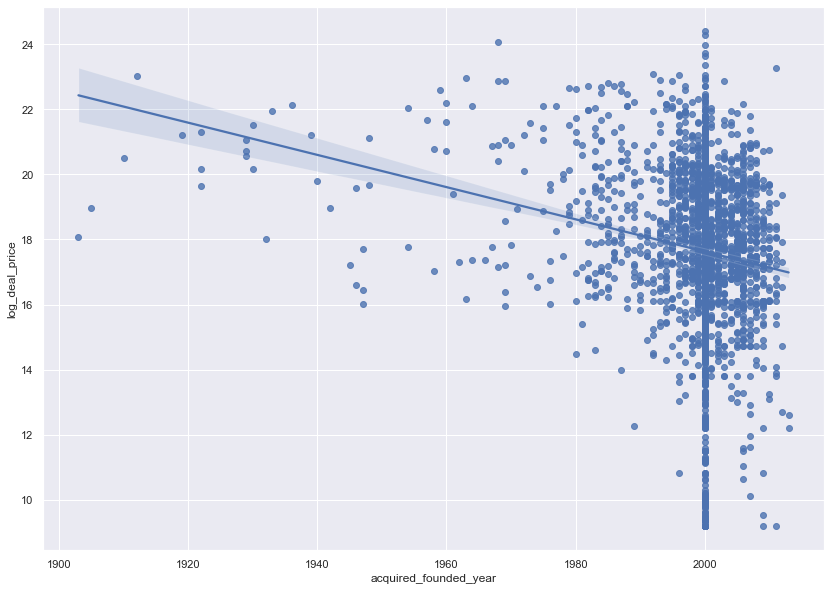

In [152]:
sns.regplot(data= df, x="acquired_founded_year", y="log_deal_price")

Text(0.5, 1.0, 'Regression plot for the age of the acquired company and log deal price')

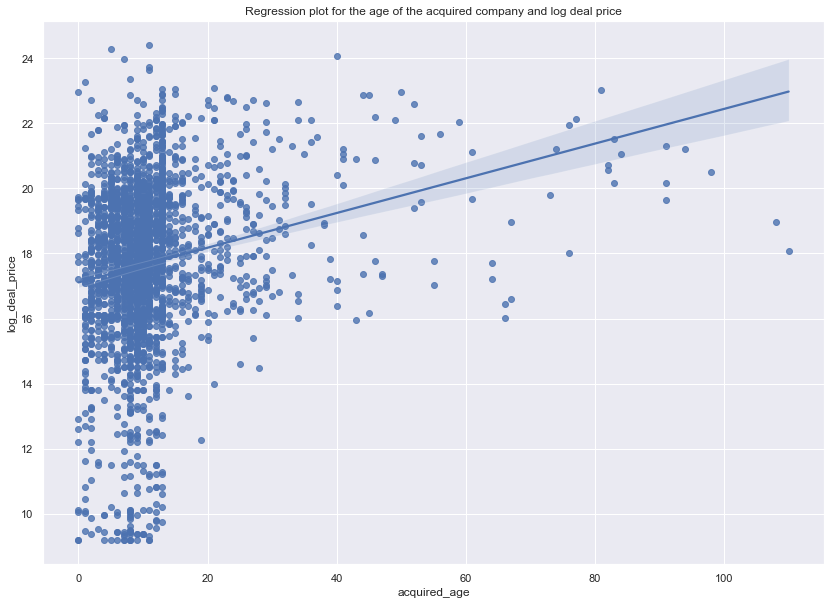

In [153]:
sns.regplot(data=df, x="acquired_age", y="log_deal_price")
plt.title("Regression plot for the age of the acquired company and log deal price")

### 2.3.2. Sector

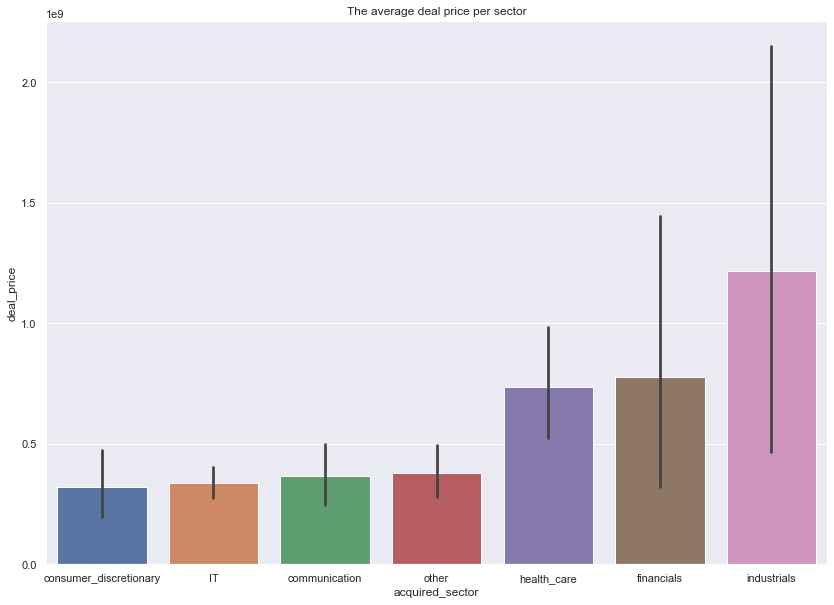

In [154]:
order = df.groupby("acquired_sector")['deal_price'].aggregate(np.mean).reset_index().sort_values("deal_price")["acquired_sector"]
sns.barplot(data=df, x="acquired_sector", y="deal_price", order=order)
plt.title("The average deal price per sector")
plt.savefig(r"C:\Users\32474\Documents\Ma TEW\masterthesis\grafieken\acquired_price_per_sector")

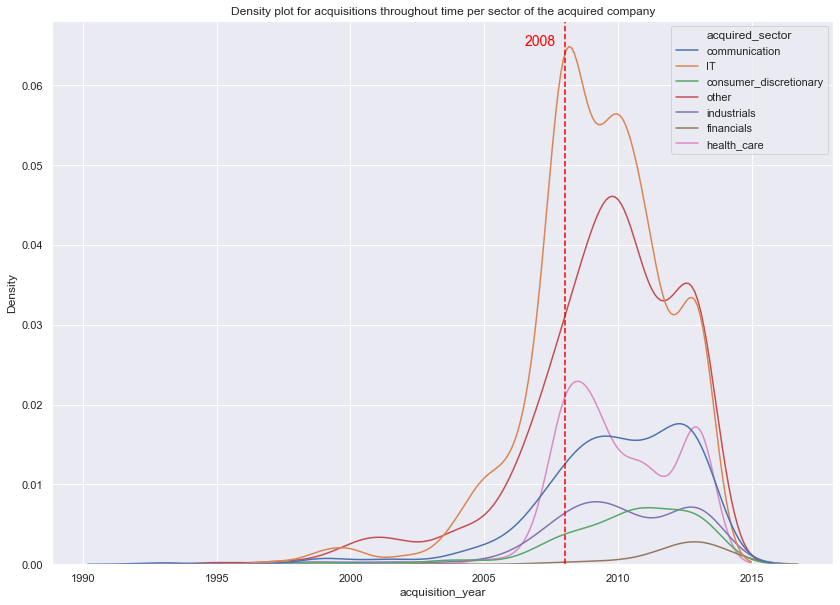

In [155]:
sns.kdeplot(data=df, x="acquisition_year", hue="acquired_sector")
plt.axvline(2008, color = "red", linestyle = "--")
plt.text(2006.5, 0.065, "2008", fontsize=14, color="red")
plt.title("Density plot for acquisitions throughout time per sector of the acquired company")
plt.savefig(r"C:\Users\32474\Documents\Ma TEW\masterthesis\grafieken\acquired_acquisitions_per_sector_time")

### 2.3.3. Location

Text(0.5, 1.0, 'Barplot for the average deal price per location of the acquired company')

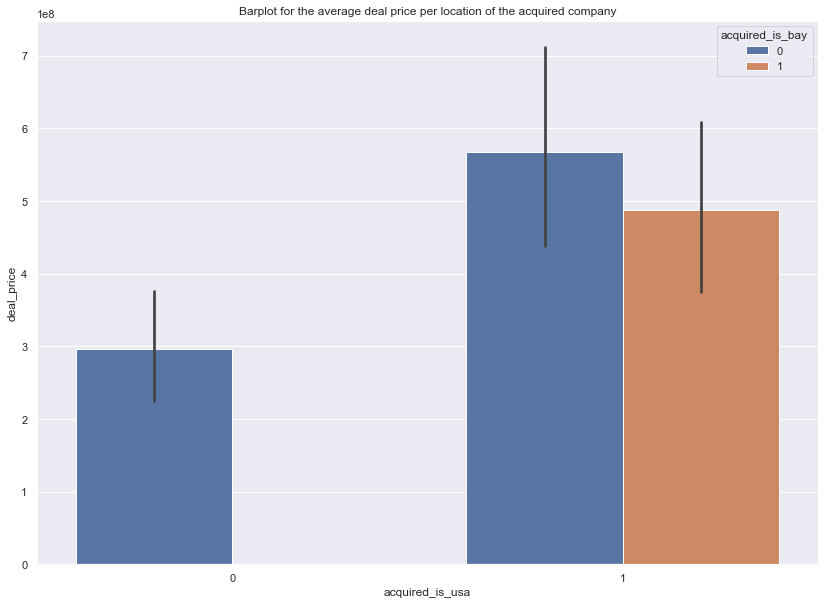

In [156]:
sns.barplot(data=df, x="acquired_is_usa", y="deal_price", hue="acquired_is_bay")
plt.title("Barplot for the average deal price per location of the acquired company")

### 2.3.4. Investment and funding

Text(0.5, 1.0, 'Regression plot for the investments of the acquired company and log deal price')

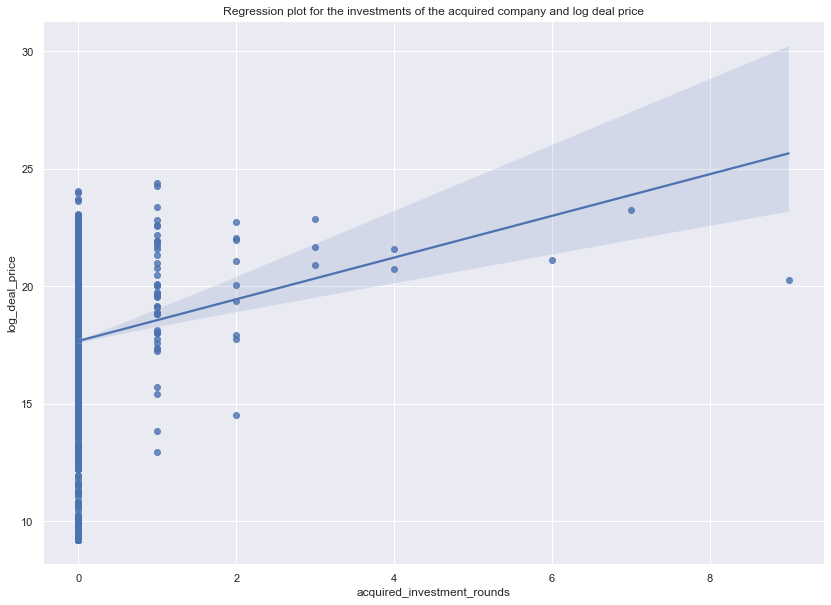

In [157]:
sns.regplot(data=df, x="acquired_investment_rounds", y="log_deal_price")
plt.title("Regression plot for the investments of the acquired company and log deal price")

Text(0.5, 1.0, 'Regression plot for the funding of the acquired company and log deal price')

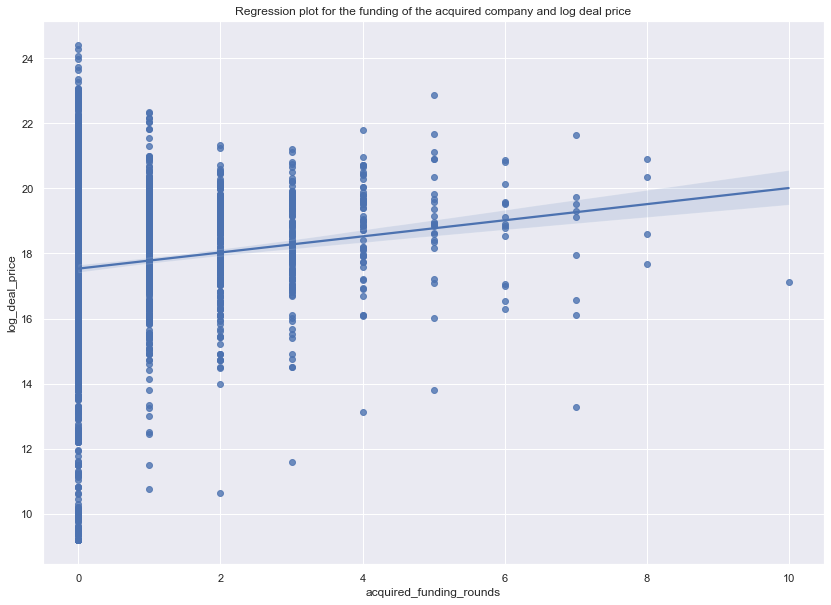

In [158]:
sns.regplot(data=df, x="acquired_funding_rounds", y="log_deal_price")
plt.title("Regression plot for the funding of the acquired company and log deal price")

Text(0.5, 1.0, 'Regression plot for the amount of funds that support the acquired company and log deal price')

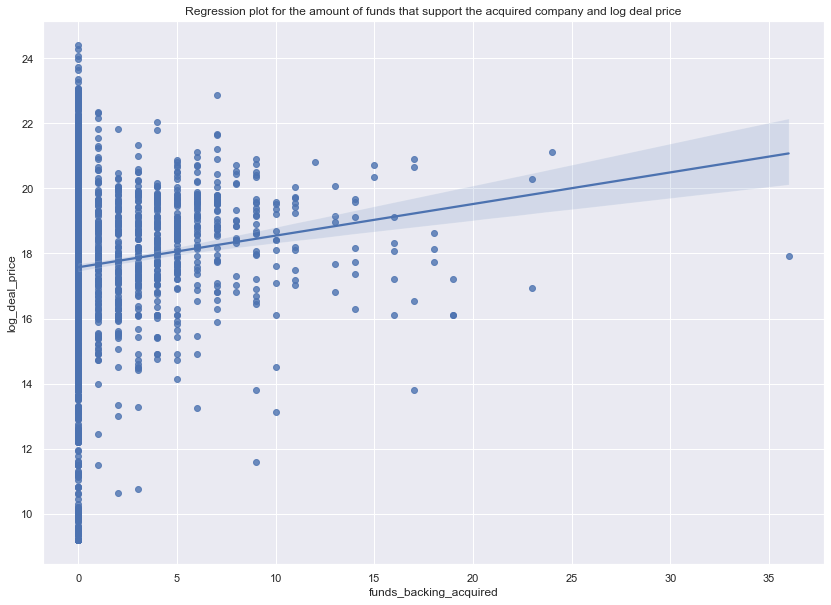

In [159]:
sns.regplot(data=df, x="funds_backing_acquired", y="log_deal_price")
plt.title("Regression plot for the amount of funds that support the acquired company and log deal price")

### 2.3.5. Size

Text(0.5, 1.0, 'Regression plot for the milestones of the acquired company and log deal price')

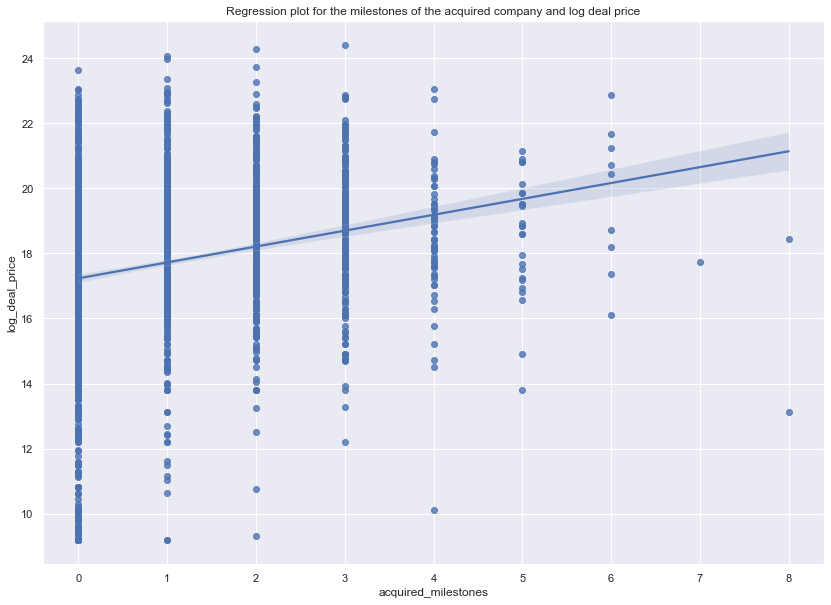

In [160]:
sns.regplot(data=df, x="acquired_milestones", y="log_deal_price")
plt.title("Regression plot for the milestones of the acquired company and log deal price")

Text(0.5, 1.0, 'Regression plot for the relationships of the acquired company and log deal price')

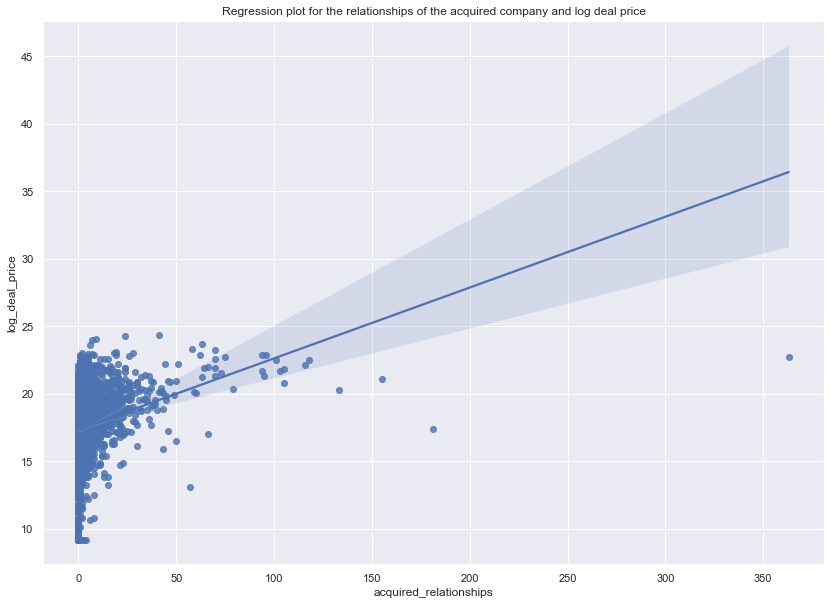

In [161]:
sns.regplot(data=df, x="acquired_relationships", y="log_deal_price")
plt.title("Regression plot for the relationships of the acquired company and log deal price")

Text(0.5, 1.0, "Regression plot for the acquired company's amount of offices and log deal price")

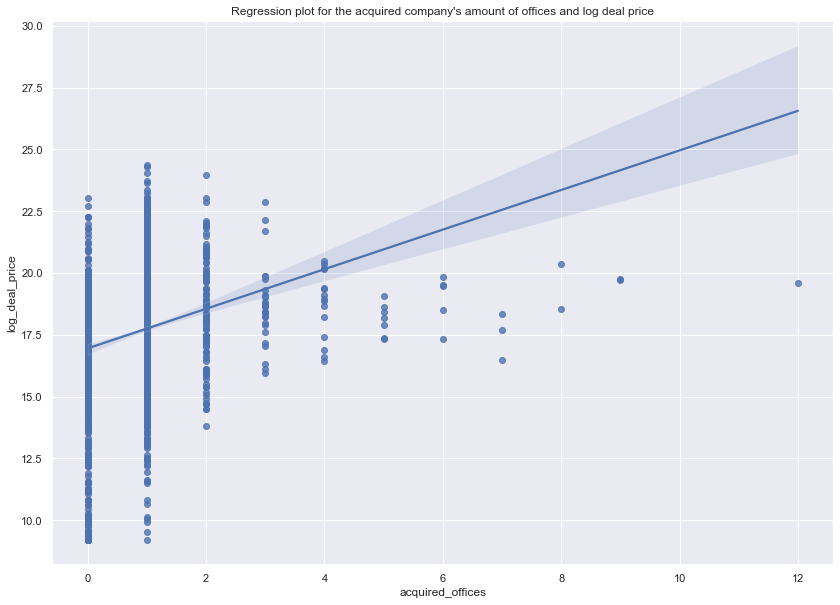

In [162]:
sns.regplot(data=df, x="acquired_offices", y="log_deal_price")
plt.title("Regression plot for the acquired company's amount of offices and log deal price")

### 2.3.6. Founder degree

Text(0.5, 1.0, 'Bar plot for the average deal price whether the founder has an advanced degree or not')

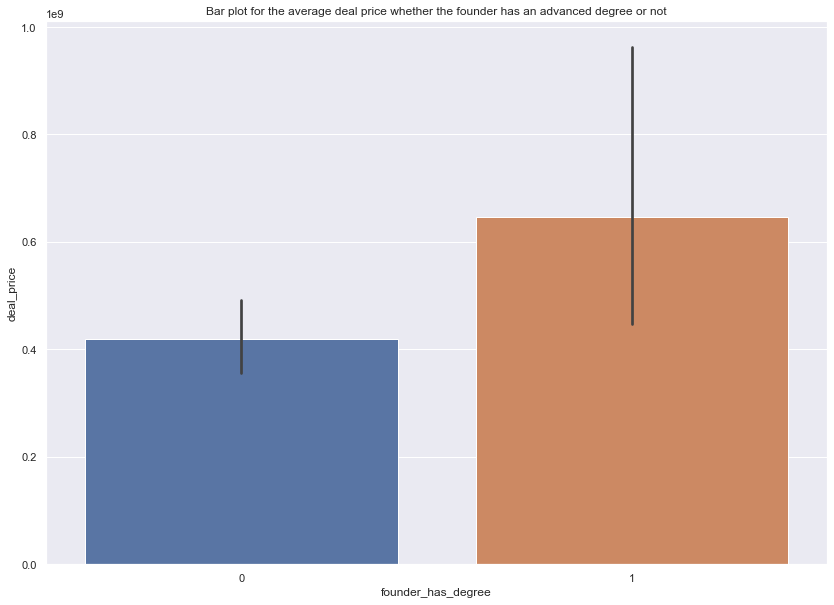

In [163]:
sns.barplot(data=df, x="founder_has_degree", y="deal_price")
plt.title("Bar plot for the average deal price whether the founder has an advanced degree or not")

# 3. Select the needed columns for modelling

In [164]:
# Create a dataframe that contains all the needed variables for modelling (slicing to remove deal_price from these lists)
df_modelling = df[acquirer_columns + acquired_columns[2:] + deal_columns[1:]]

In [165]:
df_modelling.tail()

,log_deal_price,deal_price,acquirer_investment_rounds,acquirer_funding_rounds,acquirer_milestones,acquirer_relationships,acquirer_founded_year,acquirer_offices,acquirer_is_usa,acquirer_is_bay,...,acquired_sector_communication,acquired_sector_consumer_discretionary,acquired_sector_financials,acquired_sector_health_care,acquired_sector_industrials,acquired_sector_other,acquired_age,acquisition_year,same_country,same_sector
2576,18.370608,9.511604e+07,0,0,0,1,1980,1,0,0,...,0,0,0,0,0,0,5,2013,0,1
2577,21.639557,2.500000e+09,0,0,0,3,1985,1,0,0,...,0,0,0,0,0,1,13,2013,0,1
2578,19.218188,2.220000e+08,0,0,0,5,1994,1,1,0,...,0,0,0,1,0,0,13,2013,1,1
2579,23.981362,2.600000e+10,5,0,2,14,1985,1,1,0,...,0,0,0,0,0,1,7,2007,0,0
2580,17.567365,4.260000e+07,0,5,5,21,2005,1,1,0,...,1,0,0,0,0,0,2,2013,1,0


In [166]:
df_modelling.to_excel(r"C:\Users\32474\Documents\Ma TEW\masterthesis\data\modelling_data.xlsx")

In [167]:
df_modelling.dtypes

log_deal_price                            float64
deal_price                                float64
acquirer_investment_rounds                  int64
acquirer_funding_rounds                     int64
acquirer_milestones                         int64
acquirer_relationships                      int64
acquirer_founded_year                       int64
acquirer_offices                            int64
acquirer_is_usa                             int32
acquirer_is_bay                             int32
acquirer_sector_IT                          uint8
acquirer_sector_communication               uint8
acquirer_sector_consumer_discretionary      uint8
acquirer_sector_financials                  uint8
acquirer_sector_health_care                 uint8
acquirer_sector_industrials                 uint8
acquirer_sector_other                       uint8
acquirer_number_of_acquisitions             int64
acquirer_age                                int64
acquired_investment_rounds                  int64


In [168]:
df_modelling.shape

(2478, 40)